<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<center>
<H1 align='center'> INF-395 Redes Neuronales Artificiales 2019-1</H1>

<H3 align='center'> Tarea 2 - Redes Neuronales y *Deep Learning* </H3>
</center>
<hr style="height:2px;border:none"/>

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_



<hr style="height:2px;border:none"/>

In [50]:
import numpy as np
import os 
import matplotlib.pyplot as plt
from PIL import Image
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA

from keras.models import Sequential, Model
from keras.layers import merge, Dropout, Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Input, Activation, SpatialDropout2D
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.regularizers import l1,l2
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.applications.vgg16 import VGG16
from keras.initializers import Identity 

from skimage import filters

from IPython.display import SVG
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

En el siguiente experimento se experimentará con el uso de redes neuronales para realizar _**image segmentation**_, que es un proceso en que se particiona una imagen digital en múltiples segmentos de interés, con el objetivo de simplificarla y/o cambiar su representación en algo con más significado y fácil de analizar. Esta tarea tiene múltiples aplicaciones, donde se puede destacar el uso medicinal para la detección de distintas patologías, y la detección de distintos objetos, la cual es el núcleo de los autos de conducción automática.

Se utiliza un dataset utilizado para realizar benchmark en el área, el cual es bastante pequeño, lo que supone un gran problema al momento de entrenar las redes que se diseñan.

A continuación se carga el dataset a utilizar, donde se destaca el redimensionamiento de las imágenes, pues no todas cuentan con las mismas dimensiones. Se elige utilizar imágenes de _**(100 x 100)**_, cuyo criterio de elección fue ir subiendo poco a poco las dimensiones desde _**(32 x 32)**_ hasta que la visualización de la imagen fuera agradable a la vista.

In [3]:
def charge_images(img_size, folder):
    X_image= []
    data = [archivo.split(".")[0] for archivo in os.listdir(folder+"/image")]
    for archivo in data:
        I = Image.open("{}/image/{}.jpg".format(folder,archivo))
        I = np.asarray(I.resize((img_size,img_size),Image.ANTIALIAS))
        X_image.append(I)
    X_image = np.asarray(X_image)
    Y_image = []
    for archivo in data:
        I = Image.open("{}/ground-truth/{}.png".format(folder,archivo))
        I = np.asarray(I.resize((img_size,img_size),Image.ANTIALIAS))
        Y_image.append(I)
    Y_image = np.asarray(Y_image)
    return X_image, Y_image
        

In [4]:
img_size = 100
img_shape = (100,100,3)
folder = "Semantic dataset100"

In [5]:
X_image, Y_image = charge_images(img_size,folder)

> _**a) Explore los datos a trabajar, visualice la entrada y salida del modelo, además de las dimensionalidades de éstas ¿Es un problema las dimensiones de los datos versus la cantidad de datos a entrenar? Normalice los datos como se acostumbra en imágenes y genere una dimensión/canal extra a la salida.**_

El dataset se compone de 200 imágenes: 100 que se utilizarán como input y 100 que cuentan con la segmentación de la imagen deseada. Cada una de estas imágenes posee 3 canales (RGB). Tal como se mencionó anteriormente, cada uno de estos canales es de $100 x 100$. Hay que destacar que la salida debería ser de un solo canal, el cual no está presente en el dataset original, por lo que es necesario agregar esta dimensión en dicho conjunto.

A continuación se presentan 9 imágenes, con su respectiva salida, elegidas aleatoriamente desde el conjunto completo.

In [6]:
X_image.shape

(100, 100, 100, 3)

In [7]:
Y_image.shape

(100, 100, 100)

In [8]:
def show_9_images(X_image,Y_image):
    plt.figure(figsize=(10,40))
    for i in range(1,20,2):
        random = np.random.randint(0,X_image.shape[0])
        plt.subplot(10,2,i)
        plt.imshow(X_image[random])
        plt.subplot(10,2,i+1)
        plt.imshow(Y_image[random])
    plt.show()

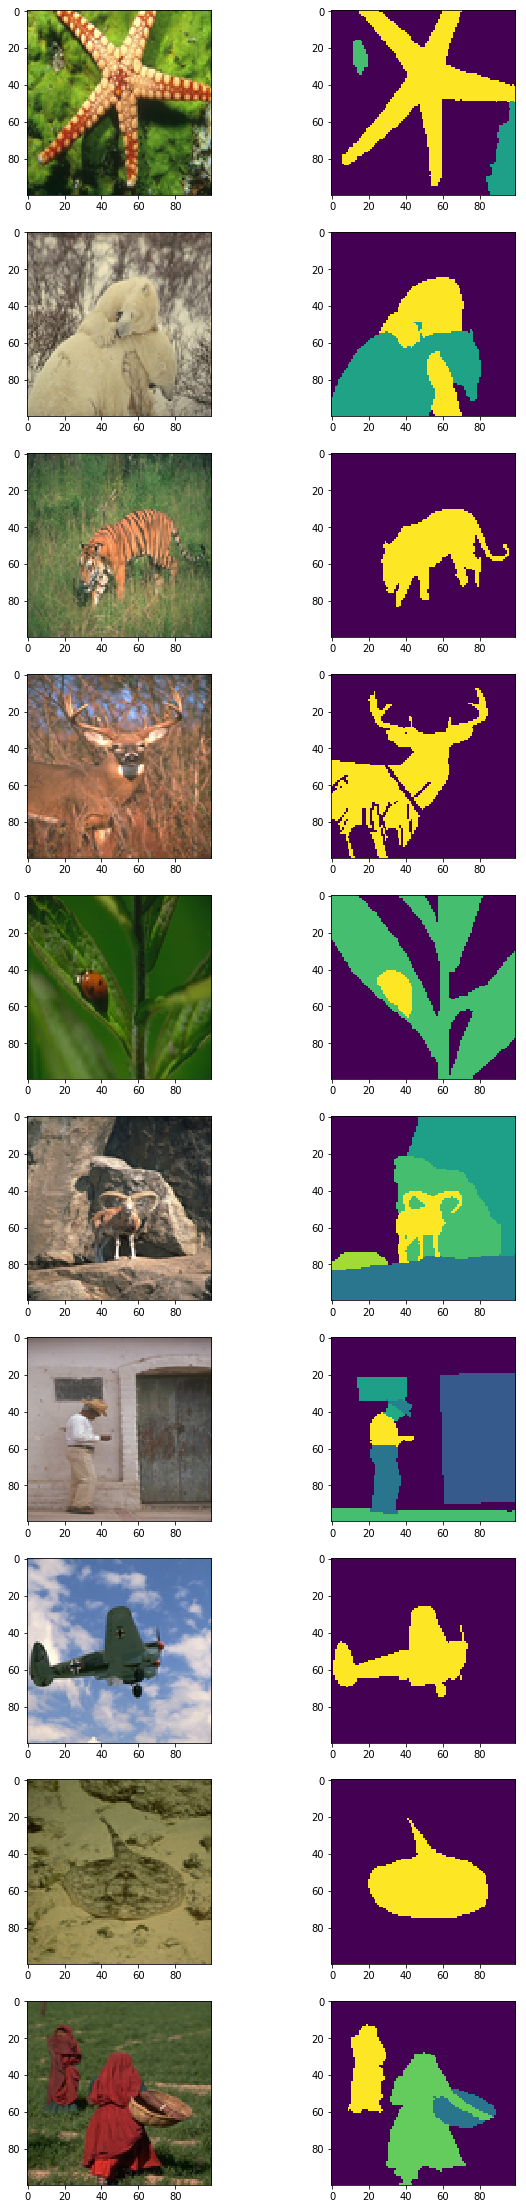

In [9]:
show_9_images(X_image,Y_image)

Tal como se puede observar en las imágenes, a pesar de contar con tan pocas imágenes, estas tienen temáticas muy distintas entre sí (personas, paisajes, animales, medios de transporte, etc), por lo que la poca cantidad de imágenes dificultará la detección de patrones dentro de estas, dada su dispersión en terminos de contenido.

Como es habitual al trabajar con imágenes, se normalizan los pixeles de estas dividiendo por $255$, el cual es el máximo valor al utilizar imágenes RGB.

In [10]:
X_image = X_image/255.
Y_image = Y_image/255.
Y_image = Y_image[:,:,:,None]

Tal como se vió en las imágenes anteriores, la salida tiene distintas intensidades de pixeles, por lo que el problema a resolver se trata de segmentación de imágenes en múltiples segmentos. Entre todas las imágenes del conjunto existen 63 intensidades distintas para los pixeles.

In [11]:
print(np.unique(Y_image))
len(np.unique(Y_image))

[0.         0.02745098 0.15686275 0.23529412 0.24705882 0.25098039
 0.2627451  0.28235294 0.28627451 0.29019608 0.29411765 0.29803922
 0.30980392 0.32156863 0.3254902  0.32941176 0.35686275 0.37254902
 0.38823529 0.39215686 0.40392157 0.41960784 0.42352941 0.43529412
 0.43921569 0.45490196 0.47058824 0.48235294 0.49803922 0.50196078
 0.51372549 0.51764706 0.52941176 0.54901961 0.56078431 0.56470588
 0.56862745 0.57254902 0.57647059 0.59215686 0.60784314 0.62352941
 0.63921569 0.70196078 0.70588235 0.70980392 0.71764706 0.73333333
 0.74901961 0.76078431 0.76470588 0.78039216 0.82745098 0.84705882
 0.85882353 0.8627451  0.87843137 0.88235294 0.89019608 0.9254902
 0.98823529 0.99607843 1.        ]


63

> _**b) Separe 10 imágenes como conjunto de pruebas para verificar la calidad del modelo entrenado.**_

Se separan los conjunto de 100 imágenes en los clásicos conjuntos de entrenamineto y de pruebas. Como se cuenta con tan pocas imágenes, el conjunto de pruebas cuenta solo con 10 imágenes, dejando 90 para el entrenamiento de las redes a utilizar.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_image,Y_image,test_size=0.1,random_state=42) 

In [13]:
x_test.shape

(10, 100, 100, 3)

> _**c) Debido a la poca cantidad de datos presentes defina la arquitectura utilizando únicamente convolucionales (fully convolutional). Comente sobre los cambios en la dimensionalidad a través del forward pass. Decida el tamaño del batch en base a la cantidad de datos que se presenta para entrenar.**_

Debido a la poca cantidad de datos en los conjuntos, se utilizará una arquitectura _**fully convolutional**_, la cual cuenta solo con capas convolucionales evitando capas _**fully connected**_, para que no aumente mucho el número de parámetros y evitar overfit.

Además, la arquitectura será del tipo _**encoder-decoder**_, en la cual la red se separa en dos partes: el encoder, el cual va realizando transformaciones mientras baja la dimensionalidad; y el decoder, el cual toma la representación de menor dimensionalidad entregada por el encoder y aumenta la dimensionalidad hasta generar la salida de la imagen.

<h6>Ejemplo de una arquitectura encoder-decoder fully convolutional</h6>
<img src='https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/1779b6a17ee68afafb6801477b165f19901689b2/3-Figure2-1.png'>


En este caso, utilizando el código brindado como ejemplo, para el encoder se utilizará la configuración de dos capas convolucionales seguidas de una capa de pooling, reduciendo las dimensiones de $100 x 100$ a $50 x 50$ y luego a $25 x 25$, aumentando los filtros del input en potencias de 2, comenzando con $32$ y terminando con $128$. Para el decoder, se utilizará una capa de up-sampling seguida de dos capas convolucionales transpuestas sin strides, dejando la imagen de $50 x 50$, finalizando con una nueva capa convolucional transpuesta, esta vez con strides $2 x 2$, para obtener como salida una imagen de $100 x 100$ con 3 canales. Por otro lado, se utilizarán activaciones ReLu para cada capa salvo la capa final que es sigmoidal. Lo anterior debido a que esperamos pixeles con valores entre 0 y 1. La función de perdida a utilizar será _**binary crossentropy**_, pues se verá este problema como uno de clasificación pixel a pixel.

In [14]:
def get_convolutional():
    model = Sequential()
    #Lets do the Encoder
    model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=X_image.shape[1:]))
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    #Decoder Time
    model.add(UpSampling2D((2,2)))
    model.add(Conv2DTranspose(32,(3,3),activation='relu',padding='same'))
    model.add(Conv2DTranspose(32,(3,3),activation='relu',padding='same'))
    model.add(Conv2DTranspose(1,(3,3),strides=(2,2),activation='sigmoid',padding='same'))
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer='rmsprop')
    return model

A continuación se puede ver la arquitectura utilizada, en conjunto a los cambios que sufre el input durante el _forward pass_ y la cantidad de parámetros de cada capa.

In [15]:
conv_model = get_convolutional()
# plot_model(conv_model)
# SVG(model_to_dot(conv_model).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 128)       73856     
__________

Finalmente se entrena el modelo utilizando el conjunto de entrenamiento, se utiliza un batch de 30 imágenes debido a la cantidad de imagenes que tiene el conjunto, por lo que se realizarán 3 actualizaciones a los pesos por cada uno de los 100 epochs a utilizar.

In [16]:
train_hist = conv_model.fit(x_train,y_train,epochs=100,batch_size=30,validation_data=(x_test,y_test))

Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 12s 130ms/step - loss: 1.1762 - val_loss: 0.6683
Epoch 2/100
90/90 [==============================] - 2s 20ms/step - loss: 0.6591 - val_loss: 0.6378
Epoch 3/100
90/90 [==============================] - 2s 20ms/step - loss: 0.6434 - val_loss: 0.6466
Epoch 4/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6386 - val_loss: 0.6253
Epoch 5/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6333 - val_loss: 0.6305
Epoch 6/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6279 - val_loss: 0.6097
Epoch 7/100
90/90 [==============================] - 2s 21ms/step - loss: 0.6212 - val_loss: 0.6522
Epoch 8/100
90/90 [==============================] - 2s 20ms/step - loss: 0.6283 - val_loss: 0.5994
Epoch 9/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5908 - val_loss: 0.6020
Epoch 10/100
90/90 [==============================] - 

90/90 [==============================] - 2s 20ms/step - loss: 0.5197 - val_loss: 0.5383
Epoch 82/100
90/90 [==============================] - 2s 21ms/step - loss: 0.4965 - val_loss: 0.6105
Epoch 83/100
90/90 [==============================] - 2s 21ms/step - loss: 0.4987 - val_loss: 0.5647
Epoch 84/100
90/90 [==============================] - 2s 20ms/step - loss: 0.4888 - val_loss: 0.5669
Epoch 85/100
90/90 [==============================] - 2s 20ms/step - loss: 0.4881 - val_loss: 0.5438
Epoch 86/100
90/90 [==============================] - 2s 20ms/step - loss: 0.4784 - val_loss: 0.5593
Epoch 87/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5082 - val_loss: 0.7136
Epoch 88/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5342 - val_loss: 0.5719
Epoch 89/100
90/90 [==============================] - 2s 20ms/step - loss: 0.4842 - val_loss: 0.6149
Epoch 90/100
90/90 [==============================] - 2s 20ms/step - loss: 0.4997 - val_loss: 0.5669
Epo

In [17]:
def loss_versus_epoch(hist):
    plt.figure(figsize=(15,5))
    plt.title("Loss versus Epoch")
    eps = [i + 1 for i in range(100)]
    plt.plot(eps, hist.history['loss'],'-o')
    plt.plot(eps,hist.history['val_loss'],'-o')
    plt.xlabel("Epochs")
    plt.ylabel("Binary Crossentropy Loss")
    plt.legend(['Train','Test'],loc='upper right')
    plt.show()

A continuación se presenta un gráfico del valor de la función de perdida versus cada epoch del entrenamiento en ambos conjuntos de datos.

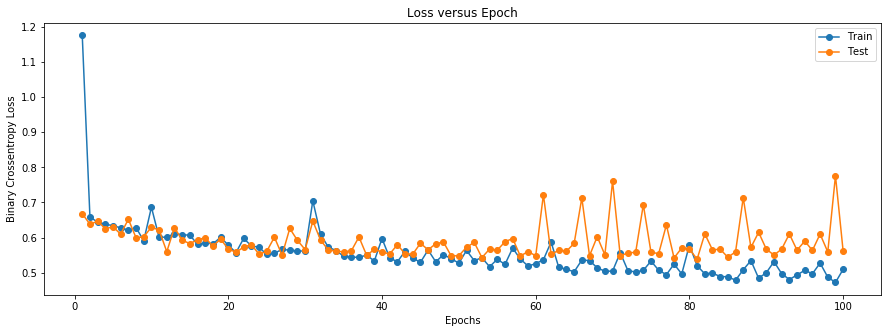

In [18]:
loss_versus_epoch(train_hist)

Se puede observar que una vez que ha pasado la mitad del entrenamiento se comienza a producir overfitting, el cual cada vez se pronuncia más, por lo que es necesario tomar medidas para tratar de remediar esto. Lo anterior se realizará más avanzado el experimento.

> _**d) Para medir el desempeño del modelo sobre ambos conjuntos realice un análisis cualitativo en base a visualizar la segmentación que realiza versus la segmentación real, además de verificar la precisión y recall asumiendo valores binarios de pixel ¿Que valor debería ser más importante, los ceros o unos? Comente.**_

Se verifica la precisión y el recall asumiendo valores binarios de pixel, donde si la intensidad del pixel es mayor a 0.5 se considerará como 1 y si es menor se considerará como 0.

La precisión se calcula de la siguiente manera:

$$ \frac{TP}{TP + FP}$$

Y se entiende como la habilidad del clasificador para no marcar como positivo un ejemplo que es negativo.

En cambio, el recall se calcula de la siguiente manera:

$$ \frac{TP}{TP + FN}$$

Que se puede entender como la capacidad del clasificador para encontrar todos los ejemplos positivos.

Considerando los valores como 0 o 1, debido a que los segmentos de interés son los que tienen mayor intensidad en sus pixeles, se considera más importante los valores marcados como 1. Esto podría llevar a considerar que mientras se clasifiquen bien los pixeles de la segmentación (1), da lo mismo equivocarse en los pixeles (0), lo que no siempre es así, pues ya son conocidos algunos accidentes producidos por falsos positivos en autos con piloto automático. Dado lo anterior, es importante clasificar bien todos los ejemplos "del tipo 1", cuidando no tener falsos positivos, por lo que en este tipo de problemas hay que contar con alta precisión y alto recall.

A continuación se presenta la precisión y el recall para cada clase (0 o 1) considerando todas las imagenes del conjunto, en conjunto a la imagen real, la segmentación predicha y la segmentación real para un conjunto de imagenes elegido al azar.

In [19]:
def recall_and_precision(pred,dataset='test'):
    if dataset=='test':
        data = np.squeeze(y_test)
    else:
        data = np.squeeze(y_train)
    y_label = data.flatten() > 0.5
    y_hat_label = pred.flatten() > 0.5
    print("Precision in {} dataset: {}".format(dataset,precision_score(y_label,y_hat_label,average=None,labels=[0,1])))
    print("Recall in {} dataset: {}".format(dataset,recall_score(y_label,y_hat_label,average=None,labels=[0,1])))

In [20]:
def compare_images(model,dataset='test'):
    np.random.seed(42)
    if dataset == 'test':
        y_hat = np.squeeze(model.predict(x_test))
        data = y_test
        x_data = x_test
    else:
        y_hat = np.squeeze(model.predict(x_train))
        data = y_train
        x_data = x_train
    recall_and_precision(y_hat,dataset)
    plt.figure(figsize=(20,40))
    for i in range(1,30,3):
        random = np.random.randint(0,data.shape[0])
        plt.subplot(10,3,i)
        plt.title("Real Image")
        plt.imshow(np.squeeze(x_data[random]))
        plt.subplot(10,3,i+1)
        plt.title("Convolutional Network Segmentation")
        plt.imshow(y_hat[random])
        plt.subplot(10,3,i+2)
        plt.title("Real Segmentation")
        plt.imshow(np.squeeze(data[random]))
        
    plt.show()

#### Train dataset

La precisión en el conjunto de entrenamiento es de $\sim 0.76$ para los pixeles 0's y de $\sim 0.80$ para los pixeles 1. En el caso del recall es de $\sim 0.95$ para los 0's y de $\sim 0.37$ para los 1's.

Lo anterior indica que el clasificador falla al identificar correctamente todos los ejemplos positivos (1's), pero identificando correctamente la gran mayoría de los ejemplo negativos (0's).

Precision in train dataset: [0.78923862 0.72195854]
Recall in train dataset: [0.90970142 0.49113716]


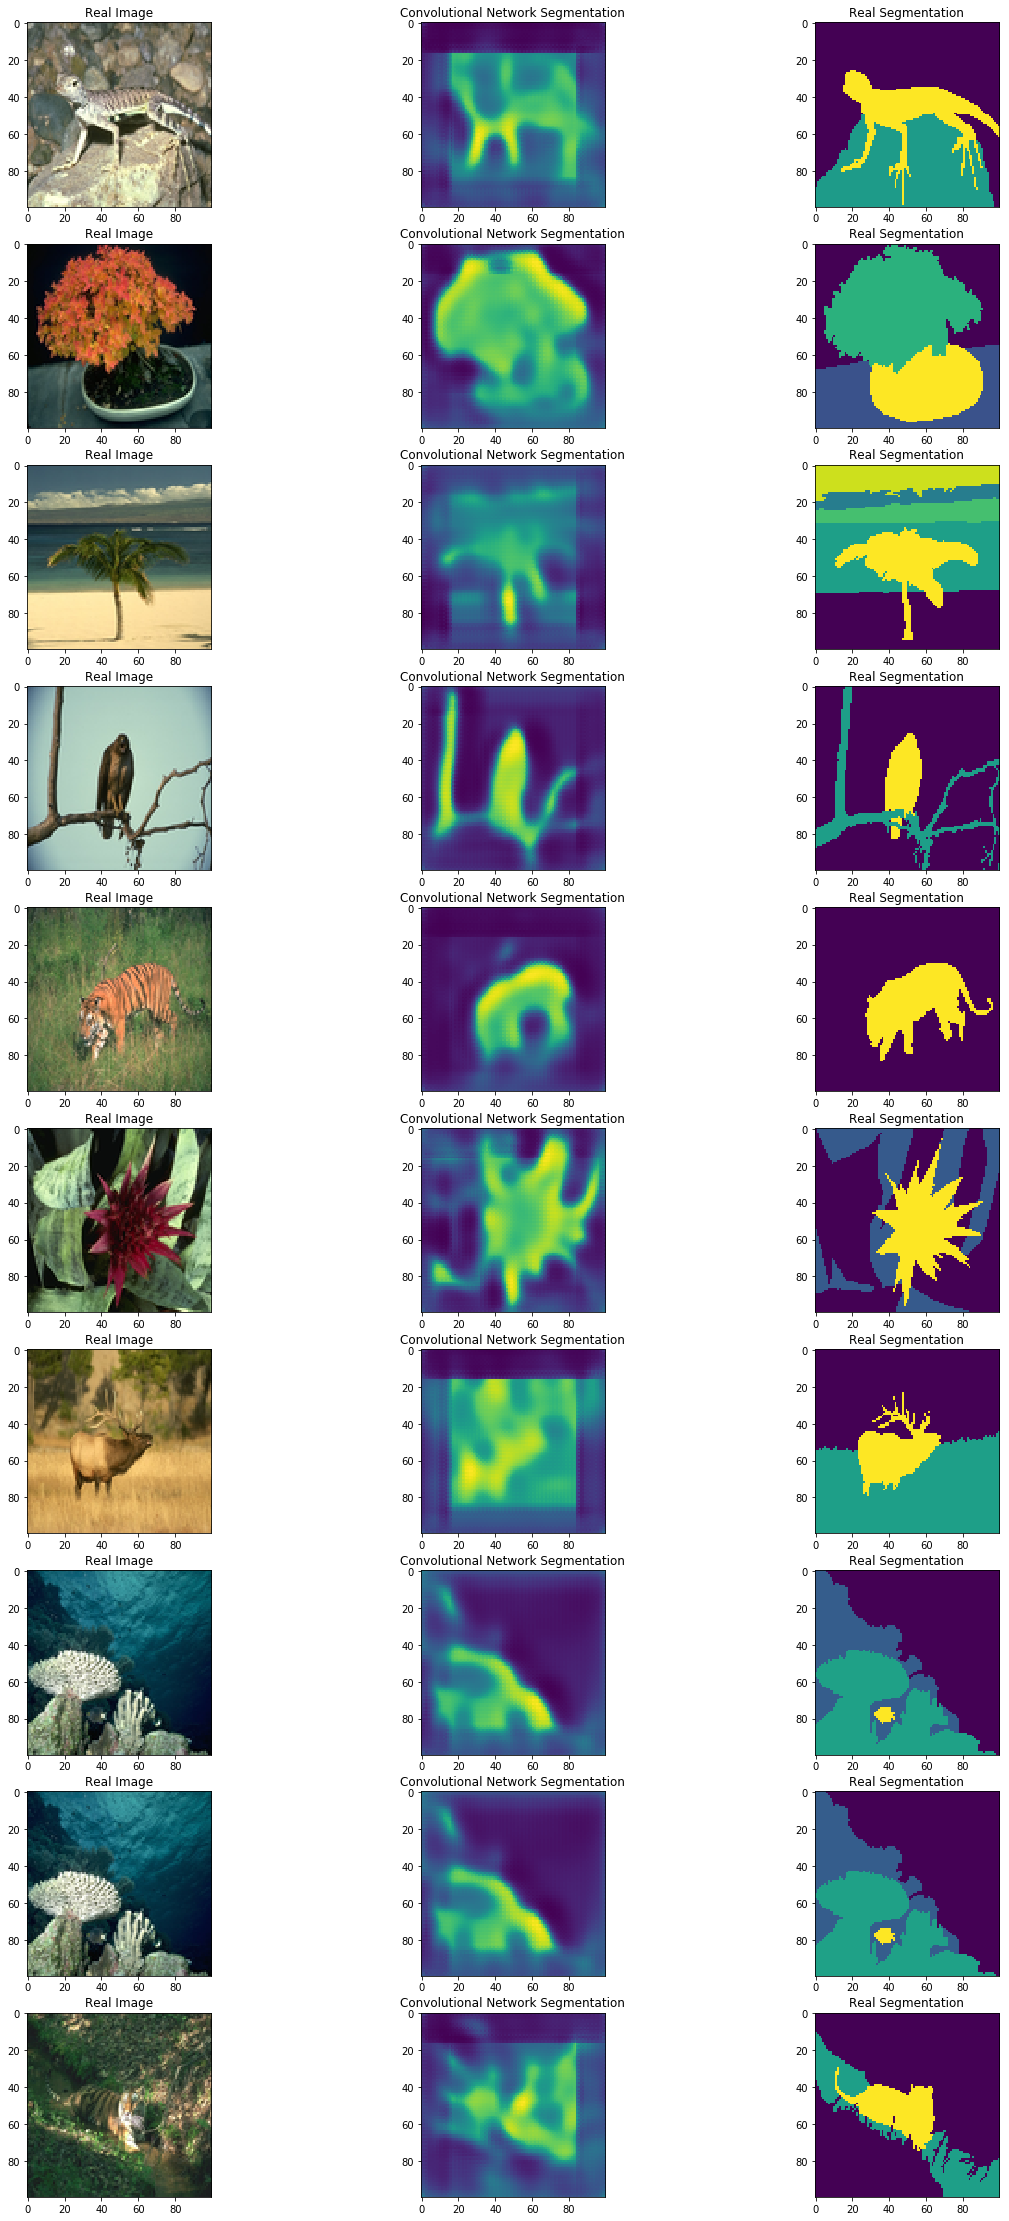

In [21]:
compare_images(conv_model,dataset='train')

Por otro lado, se puede ver que la imagen entregada por la red neuronal es bastante deficiente en comparación al output esperado, donde se logra apreciar levemente la forma de los segmentos, pero con bordes muy borrosos, donde además solo se logra captar uno de los segmentos en los casos múltiples.

#### Test Dataset

En el caso del conjunto de pruebas, se obtiene peores resultas, lo cual es esperado dado el gráfico del comportamiento durante el entrenamiento. En comparación al conjunto de entrenamiento bajan todas las métricas calculadas, para ambas clases.

Precision in test dataset: [0.74442506 0.51823955]
Recall in test dataset: [0.85839351 0.34075681]


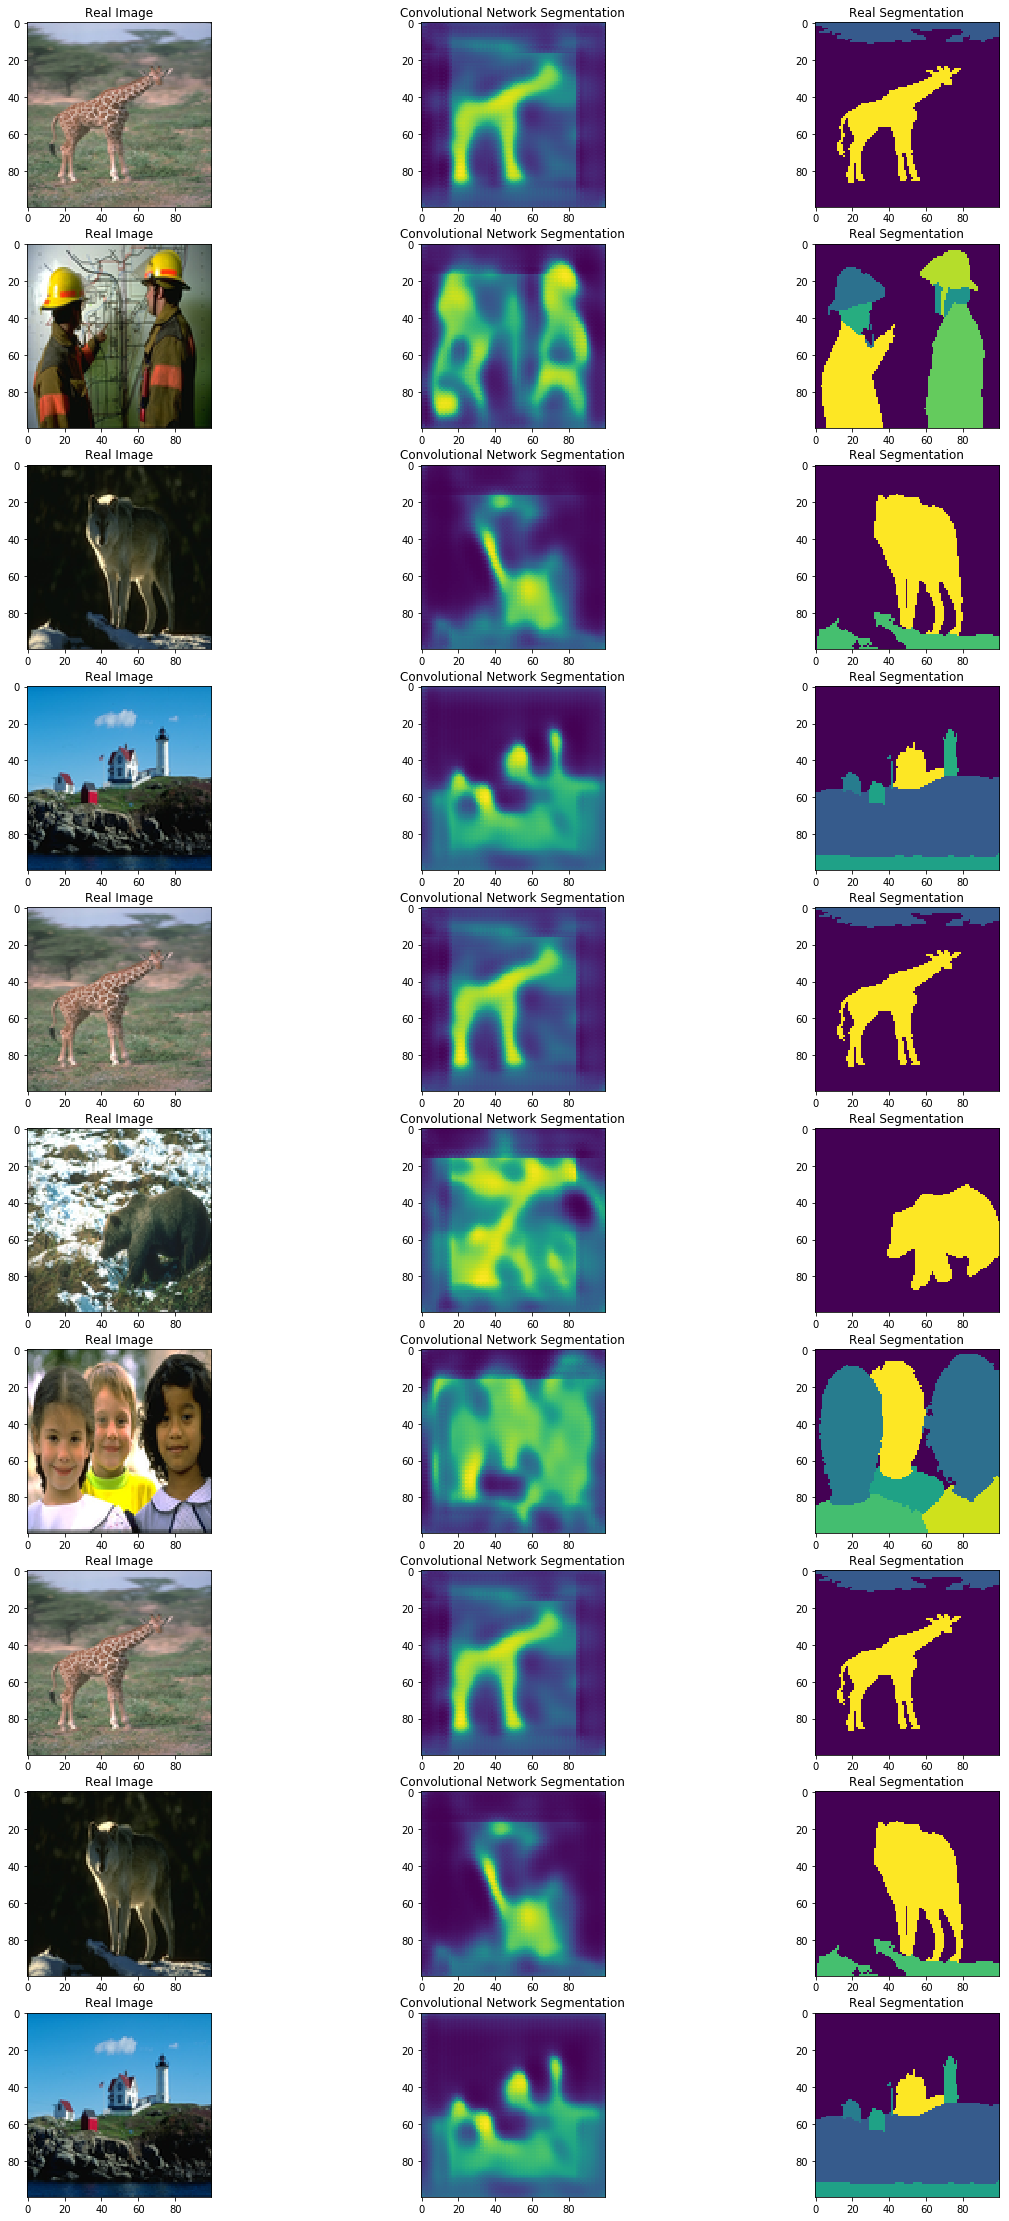

In [22]:
compare_images(conv_model)

Por otro lado, los outputs obtenidos son algo más borrosos que los obtenidos en el conjunto de entrenamiento, pero aún se logra observar la forma poco definida de los segmentos a detectar.

> _**e) Compárese con alguna técnica manual de Image Segmentation, comúnmente se sugiere considerar un treshold para activar o apagar un pixel. Experimente con utilizar treshold igual a la media o con otra técnica más inteligente basada en los histogramas de escala de grises, como se utilizan en skimage.**_

A continuación se comparan las imágenes obtenidas con la red neuroanl con las obtenidas a partir de técnicas manuales de segmentación. En estas se utiliza una imagen en escala de grises para luego decidir si considerar un pixel o no en base a algun umbral. En este caso se probarán dos alternativas: utilizar la media de las imágenes como valor umbral para considerar un pixel, dado como resultado un 1 si se supera dicho umbral; mientras que el otro método es utilizando un umbral basado en el _**Método de Otsu**_, el cual busca minimizar la varianza intra-clase (considerando las clases como 0 o 1), o equivalentemente maximizar la varianza interclases.

In [23]:
#Gray-Scale
gray_x = 0.2125 * X_image[:,:,:,0] + 0.7154*X_image[:,:,:,1] + 0.0721*X_image[:,:,:,2]

In [24]:
treshold_mean = gray_x.mean()
mask_mean = gray_x < treshold_mean
x_mean_segmented = mask_mean*1

In [25]:
treshold_ski = filters.threshold_otsu(gray_x)
mask_ski = gray_x < treshold_ski
x_ski_segmented = mask_ski * 1

In [26]:
def compare_treshold(mean, ski):
    plt.figure(figsize=(30,40))
    for i in range(1,40,4):
        random = np.random.randint(0,X_image.shape[0])
        plt.subplot(10,4,i)
        plt.title("Real Image")
        plt.imshow(np.squeeze(X_image[random]))
        plt.subplot(10,4,i+1)
        plt.title("Mean Treshold Segmentation")
        plt.imshow(mean[random])
        plt.subplot(10,4,i+2)
        plt.title("Skimage Treshold Segmentation")
        plt.imshow(np.squeeze(ski[random]))
        plt.subplot(10,4,i+3)
        plt.title("Real Segmentation")
        plt.imshow(np.squeeze(Y_image[random]))
    plt.show()

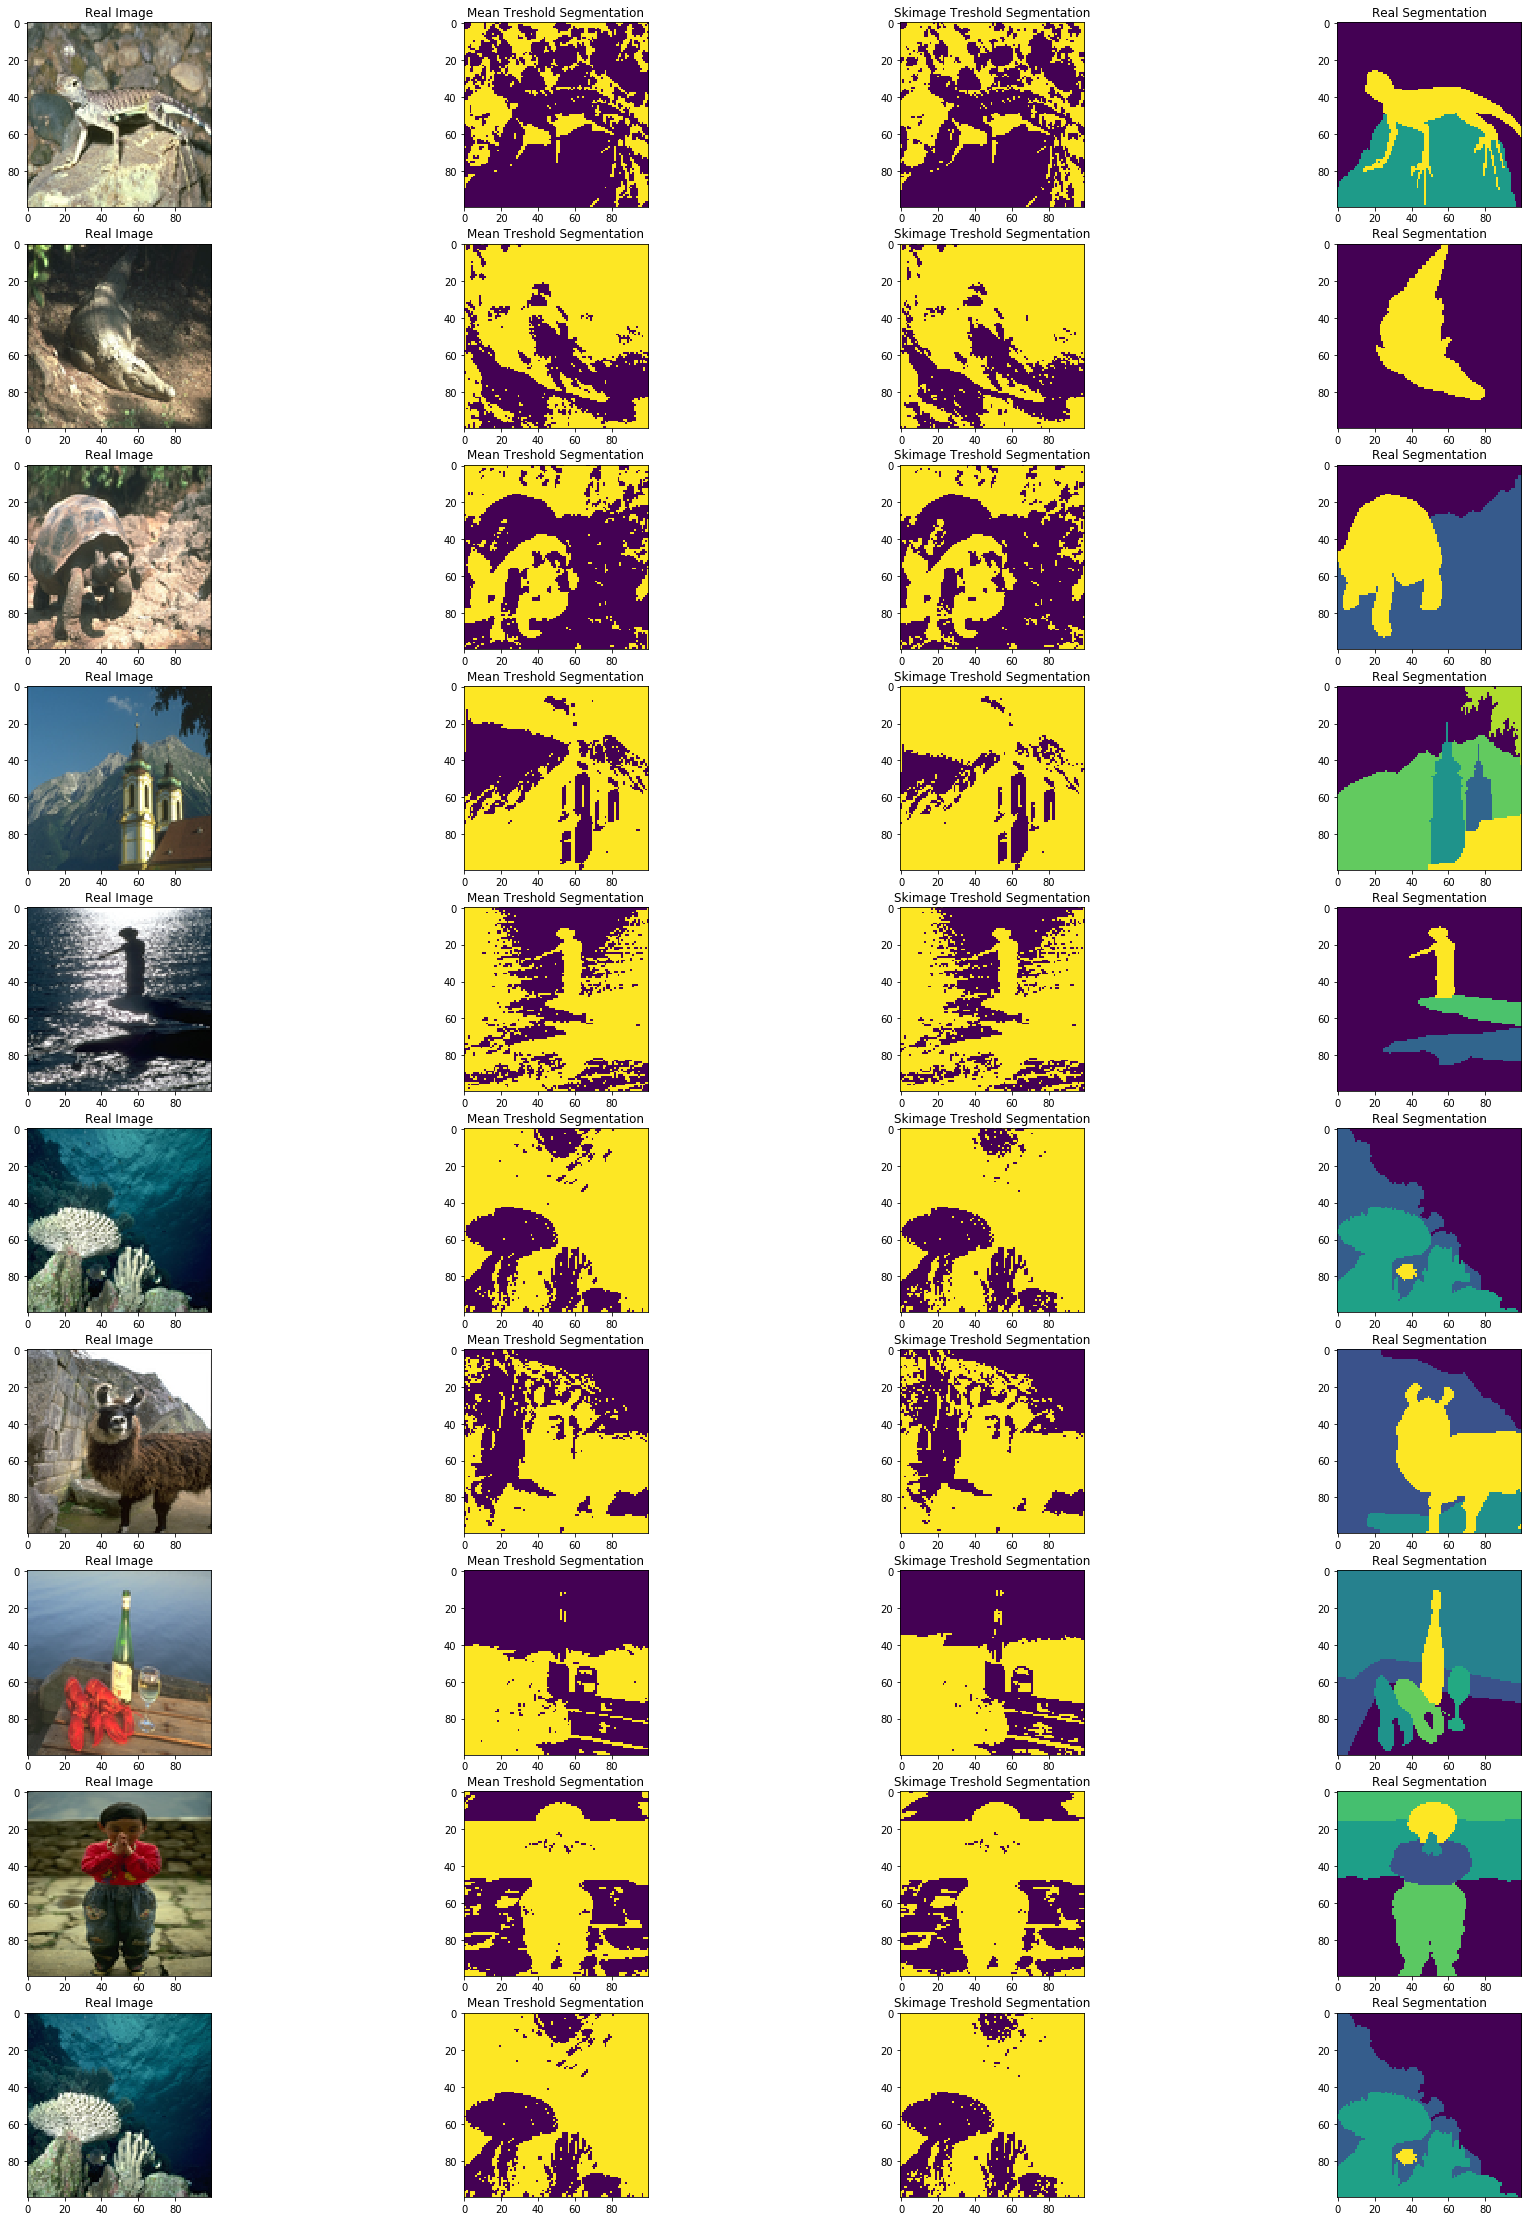

In [27]:
compare_treshold(x_mean_segmented,x_ski_segmented)

Se observan muy pocas diferencias entre utilizar la media y utilizar el método de Otsu para el umbral. Por otro lado, al contrario que las imágenes obtenidas con la red neuronal, se observan los bordes de los segmentos de manera más nítida, pero a cambio de muchas veces perder las formas de los segmentos, dando como resultado una situación completamente opuesta que la red neuronal. La red capta de manera decente la forma de los segmentos, mientras que las técnicas manuales captan de mejor manera los bordes de los segmentos.

> _**f) Experimente con realizar data augmentation sobre el problema. Debido a que las operaciones clásicas de augmentation como rotar, invertir, girar, cambiarían la etiqueta de segmentación, genere una estrategia que mantenga la etiqueta/salida Y. Se presenta un código de ejemplo, Denoising, de aplicar una máscara binaria aleatoria sobre la imagen de entrada X, de todas formas se espera que proponga alguna distinta. Compare el desempeño alcanzado con la nueva red con la forma de evaluar definida en (d).**_

Como se cuenta con muy pocas imágenes en el dataset, es necesario intentar aumentar el tamaño de este aplicando transformaciones al dataset. En este caso necesitamos mantener la imagen de salida al aplicar estas transformaciones, por lo que por el momento no es posible aplicar las operaciones clásicas como rotar, invertir, etc (salvo que se encuentre una manera de aplicar la misma transformación al input y al output).

Dado lo anterior, es necesario generar estrategias que nos permitan mantener la etiqueta para los datos aumentados, por lo que se probarán dos enfoques. El primero consiste intuitivamente en "cambiar la paleta de colores" de los ejemplos pues así se puede utilizar la misma segmentación como salida, pues serán relevantes las mismas cosas independiente del color. Para lograr lo anterior se aplicará una misma perturbación a todo un canal RGB, para así no cambiar las diferencias de intensidad entre los pixeles de un mismo canal. La perturbación será gaussiana, esto estando motivado por un método de _data augmention_ utilizado en la conocida Resnet, el cual aplica una perturbación gaussiana proporcional a la multiplicación componente a componente entre los vectores y valores propios obtenidos al aplicar PCA sobre la matriz de pixeles. En este caso se intentó dicho enfoque aplicando la misma perturbación al canal completo y no al cada pixel independiente como en la ResNet, pero se descartó el uso de PCA debido a que no se logró implementar de buena manera al no lograr mantener intensidades normalizadas entre 0 y 1 dada la magnitud de los valores propios de las componentes principales. Los parámetros de la normal utilizada son una media de 0 y una varianza de la mitad de $1 - \text{el máximo de la matriz de pixeles}$, buscando así mantener los pixeles normalizados.



In [28]:
def train_with_augmentation(model,aug):
#     pca = PCA(n_components = 3)
    for i in range(aug):
        x_aug = np.copy(X_image)
        for channel in range(3):
            channel_variation = np.ones(x_aug[:,:,:,channel].shape)*np.random.normal(loc=0,scale=(1 - np.max(x_aug[:,:,:,channel])/2))
            x_aug[:,:,:,channel] += channel_variation/np.max(channel_variation)
            #x_aug[:,:,:,channel] = x_aug[:,:,:,channel] / np.max(x_aug[:,:,:,channel])
        model.fit(x_aug,Y_image,epochs=1,batch_size=32,validation_data=(x_test,y_test))
    return model    
        
    

In [29]:
conv_model = train_with_augmentation(conv_model,100)

Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 4s 41ms/step - loss: 0.6163 - val_loss: 0.6189
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 20ms/step - loss: 0.6145 - val_loss: 0.5800
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 20ms/step - loss: 0.5510 - val_loss: 0.7429
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 20ms/step - loss: 0.6325 - val_loss: 0.5794
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 21ms/step - loss: 0.5472 - val_loss: 0.6284
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 21ms/step - loss: 0.5716 - val_loss: 0.5958
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 21ms/step - loss: 0.5509 - va

100/100 [==============================] - 2s 21ms/step - loss: 0.5088 - val_loss: 0.6361
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 21ms/step - loss: 0.5735 - val_loss: 0.5862
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 21ms/step - loss: 0.5425 - val_loss: 0.5955
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 20ms/step - loss: 0.5366 - val_loss: 0.5691
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 20ms/step - loss: 0.5376 - val_loss: 0.6136
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 20ms/step - loss: 0.5210 - val_loss: 0.5410
Train on 100 samples, validate on 10 samples
Epoch 1/1
100/100 [==============================] - 2s 20ms/step - loss: 0.5114 - val_loss: 0.5414
Train on 100 samples, validate on 10 sam

Precision in train dataset: [0.80150968 0.54054647]
Recall in train dataset: [0.75264906 0.60957084]


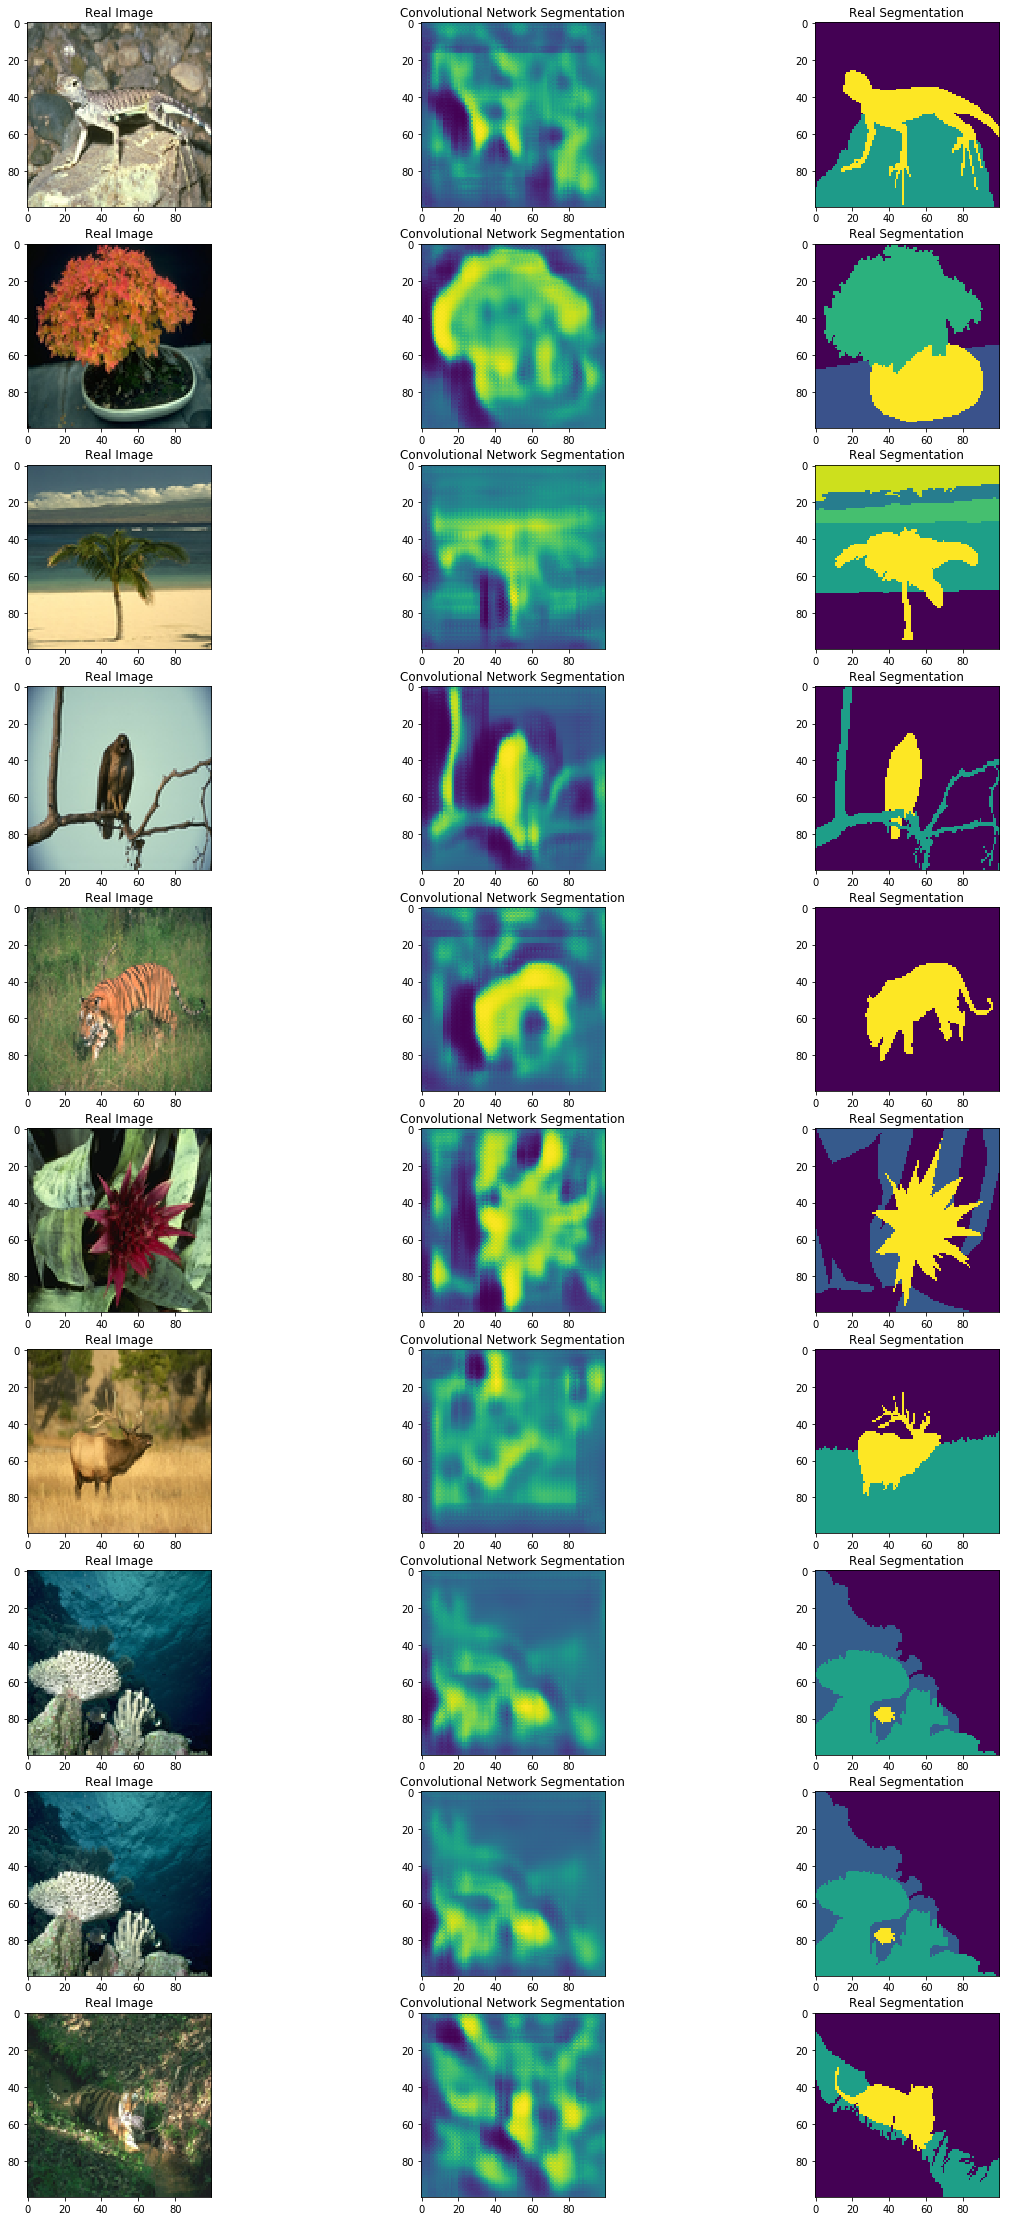

In [30]:
compare_images(conv_model,dataset='train')

Precision in test dataset: [0.79575628 0.45990036]
Recall in test dataset: [0.67997453 0.60958793]


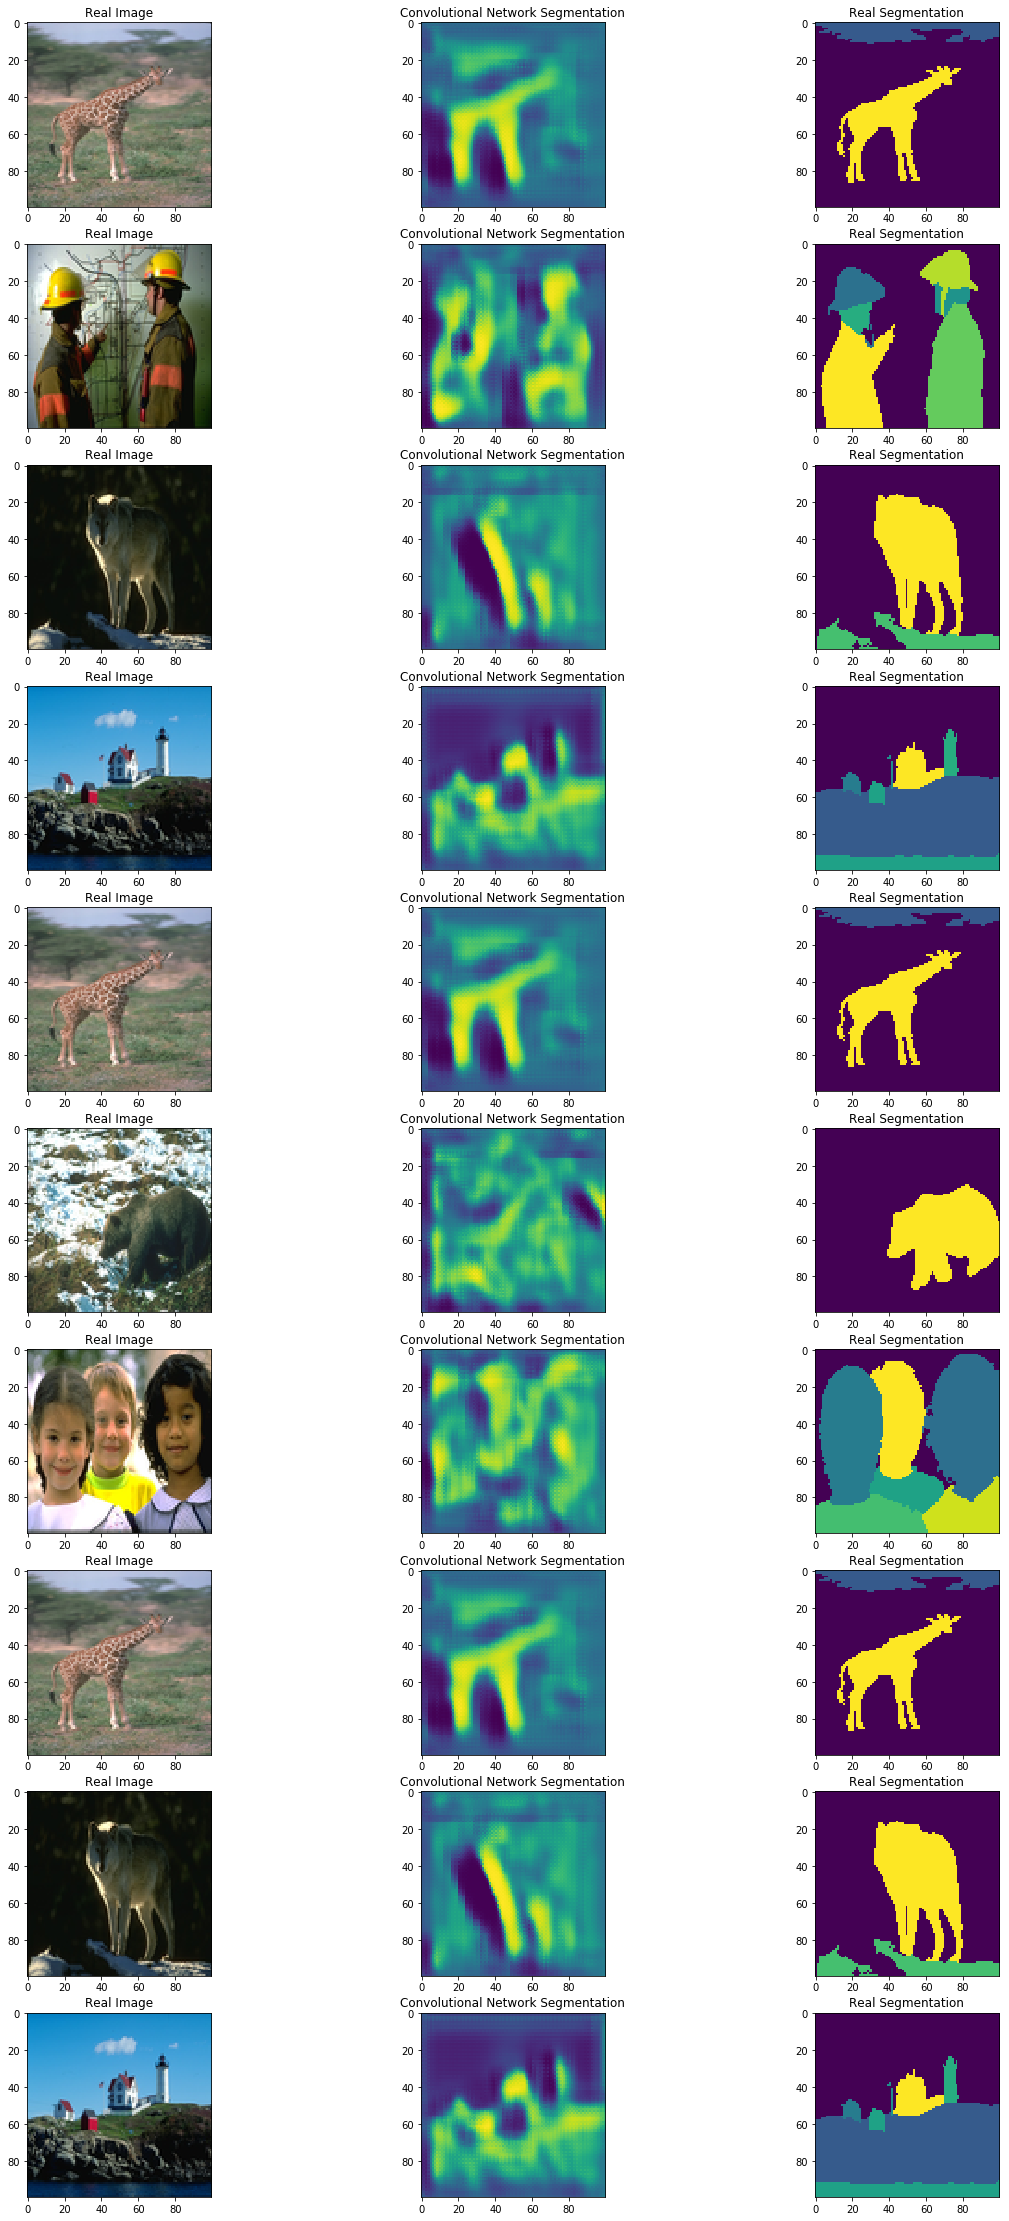

In [31]:
compare_images(conv_model)

Este enfoque empeora las métricas en comparación al entrenamiento sin data augmentation, salvo en el recall de la clase 1. Por otro lado, se observa que luego de este proceso se sigue logrando ver las formas de los segmentos, pero se producen más falsos negativos, por lo que se desestima esta manera de realizar data augmentation.

El segundo enfoque a utilizar es conocido como _**Denoising**_ el cual consiste en aplicar una máscara binaria aleatoria sobre la imagen de entrada, por lo que se apagan ciertos pixeles en los canales de la imagen de entrada. 

Para la aleatoriedad se utiliza una distribución binomial, con un p que va desde los 0.4 a 1, generando así una mascara de las mismas dimensiones que la imagen de entrada, la cual es aplicada antes de entrenar el modelo.

In [32]:
def train_with_denoising(model,aug):
    for _ in range(aug):
        noise_level = np.random.randint(4,10)/10
        noise_mask = np.random.binomial(n=1,p=noise_level,size=X_image.shape)
        x_augmented = X_image*noise_mask
        model.fit(x_augmented,Y_image,epochs=1,batch_size=32,validation_data=(X_image,Y_image))
    return model

In [33]:
conv_model_denoising = get_convolutional()
conv_model_denoising.fit(x_train,y_train,epochs=100,batch_size=30,validation_data=(x_test,y_test))
conv_model_denoising = train_with_denoising(conv_model_denoising,100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 128)       73856     
__________

Epoch 63/100
90/90 [==============================] - 2s 20ms/step - loss: 0.5420 - val_loss: 0.5371
Epoch 64/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5081 - val_loss: 0.5547
Epoch 65/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5112 - val_loss: 0.7126
Epoch 66/100
90/90 [==============================] - 2s 20ms/step - loss: 0.5876 - val_loss: 0.5421
Epoch 67/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5131 - val_loss: 0.5429
Epoch 68/100
90/90 [==============================] - 2s 21ms/step - loss: 0.5109 - val_loss: 0.5475
Epoch 69/100
90/90 [==============================] - 2s 20ms/step - loss: 0.5020 - val_loss: 0.5575
Epoch 70/100
90/90 [==============================] - 2s 20ms/step - loss: 0.5433 - val_loss: 0.5423
Epoch 71/100
90/90 [==============================] - 2s 20ms/step - loss: 0.5136 - val_loss: 0.5808
Epoch 72/100
90/90 [==============================] - 2s 20ms/step - loss: 0.4973 - val_los

100/100 [==============================] - 3s 26ms/step - loss: 0.5024 - val_loss: 0.4982
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5297 - val_loss: 0.5054
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5269 - val_loss: 0.5604
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5502 - val_loss: 0.5009
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5032 - val_loss: 0.5420
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5143 - val_loss: 0.5065
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5028 - val_loss: 0.4961
Train on 100 samples, validate on 

100/100 [==============================] - 3s 26ms/step - loss: 0.4769 - val_loss: 0.5206
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5191 - val_loss: 0.5450
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5033 - val_loss: 0.4637
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.4670 - val_loss: 0.4736
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.4789 - val_loss: 0.6057
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.5107 - val_loss: 0.5905
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 3s 26ms/step - loss: 0.4939 - val_loss: 0.4783
Train on 100 samples, validate on 

Precision in train dataset: [0.8006017 0.7436044]
Recall in train dataset: [0.91387261 0.52322907]


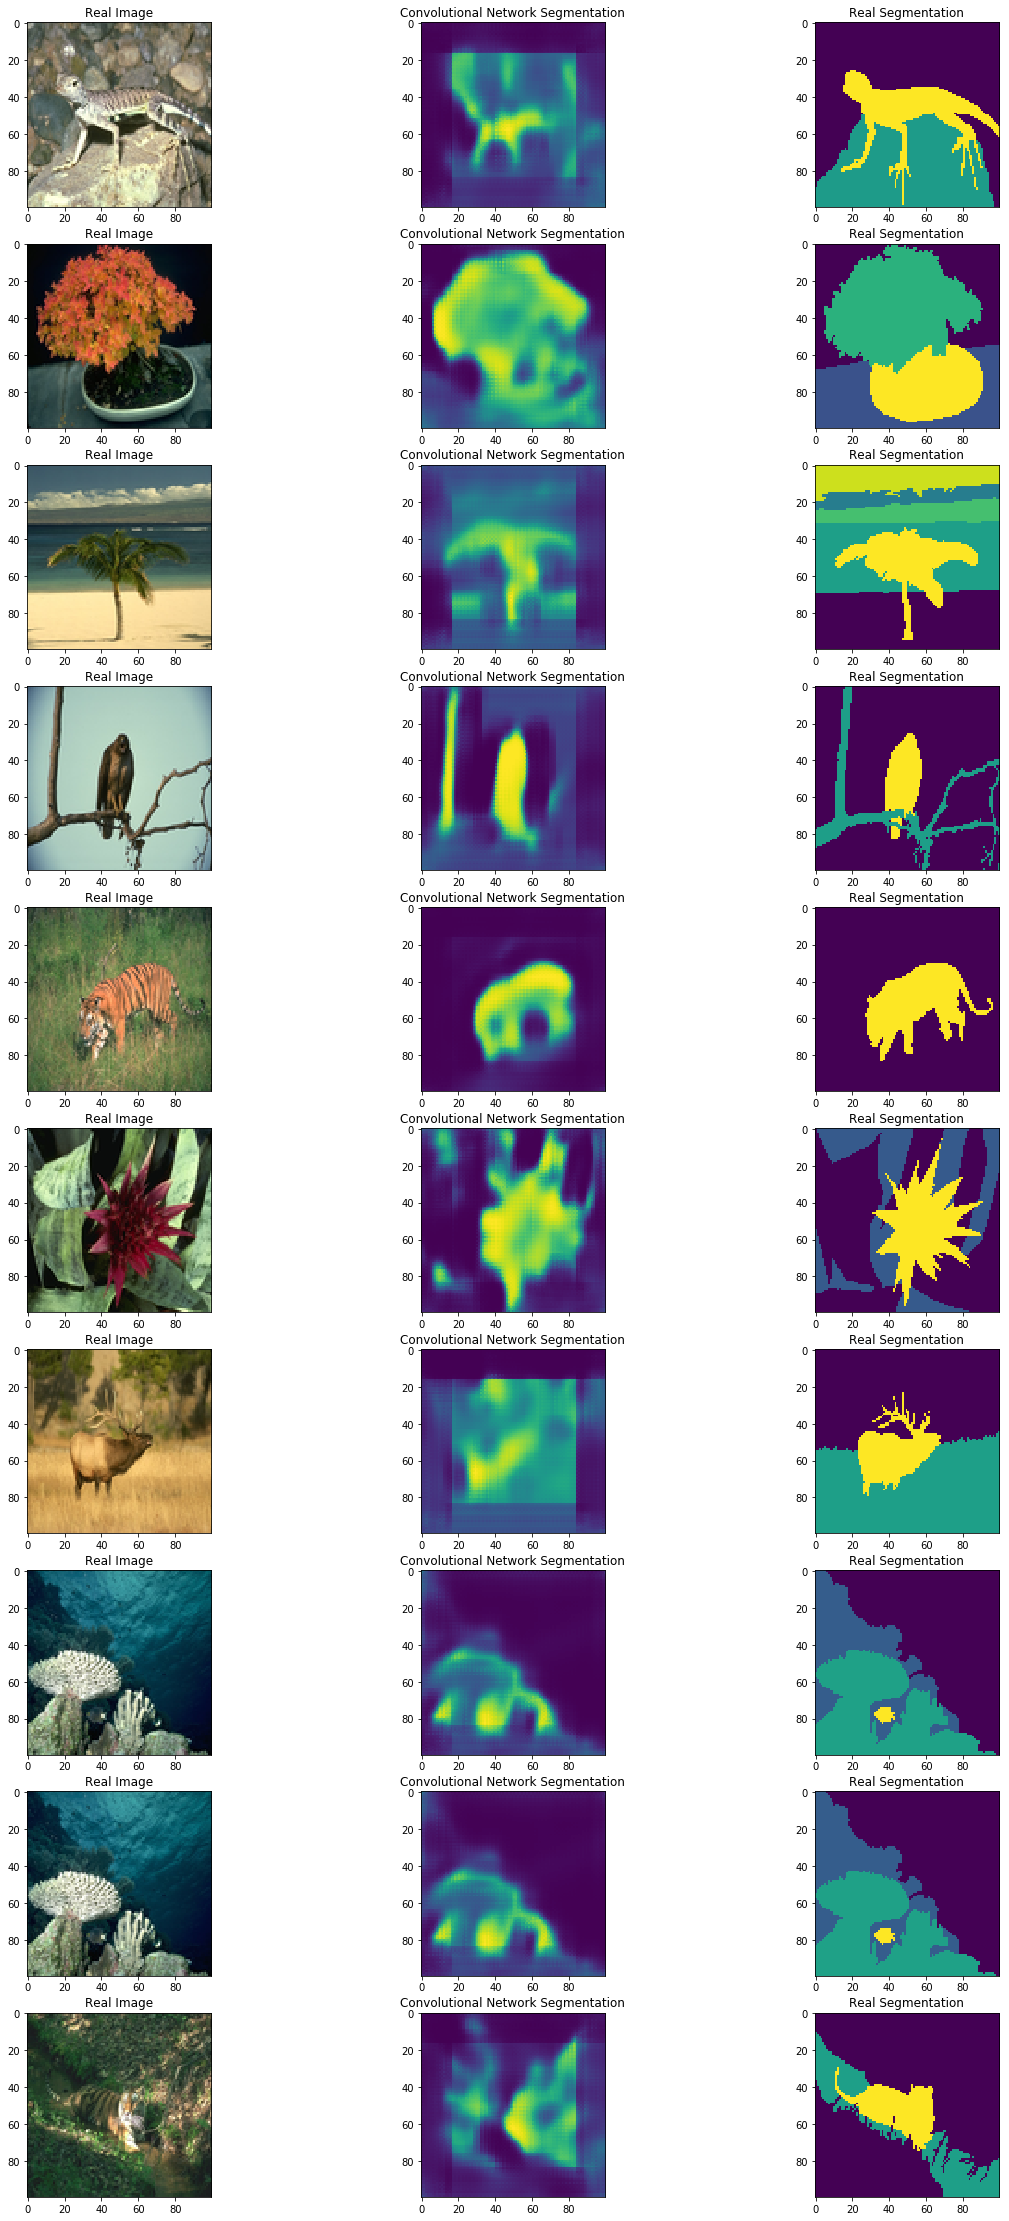

In [34]:
compare_images(conv_model_denoising,dataset='train')

Precision in test dataset: [0.81232591 0.65976251]
Recall in test dataset: [0.87354392 0.5485385 ]


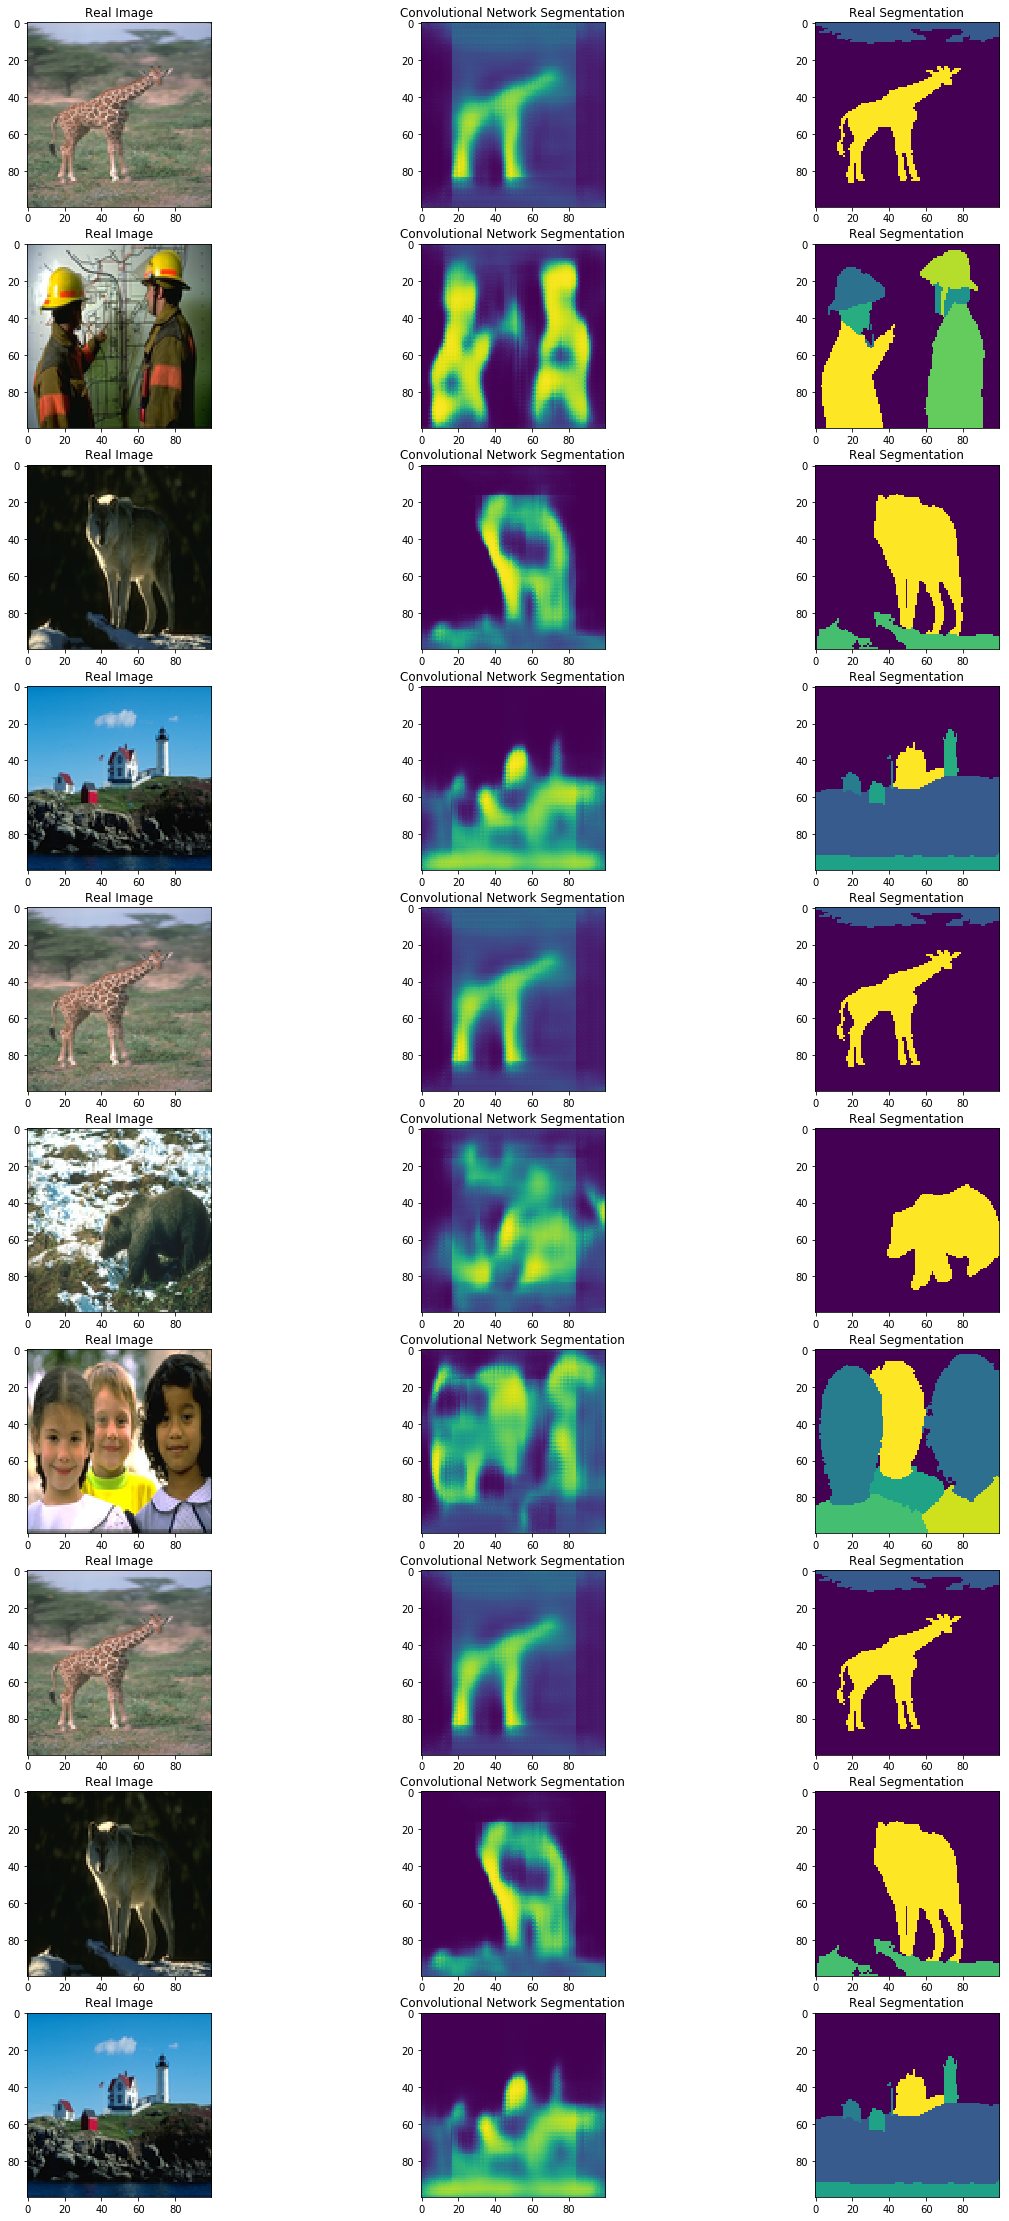

In [35]:
compare_images(conv_model_denoising)

Al utilizar el enfoque _**Denoising**_ se obtienen mejores métricas que el modelo con los datos sin aumentar, llegando a los siguientes resultados.

_**Train**_ 

_**Precision**_ - 0.78 - 0.76 
_**Recall**_ - 0.92 - 0.47 

_**Test**_ 

_**Precision**_ - 0.80 - 0.66 
_**Recall**_ - 0.88 - 0.51

Nota: Por alguna razón no se fijo una seed, por lo que es probable que los resultados cambien. Sin embargo, en todas las ejecuciones se obtiene que data augmenting utilizando Denoising funciona de mejor manera.

Obteniendo mejor Recall en el conjunto de pruebas, lo que se ve reflejado en las imagenes obtenidas, las cuales son más definidas que con las dos redes entrenadas anteriormente. Dado lo anterior, se determina que utilizar _Denoising_ es una mejor alternativa para realizar data augmention en comparación al primer enfoque intentado.

> _**g) Intente variar la arquitectura presentada en pos de obtener un mejor modelo, basado en la evaluación realizada en (d). Recuerde tomar en cuenta la poca cantidad de datos que se tiene.**_

En esta parte del experimento se intentan varias formas de mejorar la arquitectura. La primera fue reducir la complejidad de la red dada la cantidad de ejemplos, por lo que se probó una configuración de 1 capa convolucional + 1 capa de pooling, eliminando la segunda  convolucional en la parte del encoder, lo cual no tuvo buenos resultados.

Luego, y motivado por la falta de definición en los bordes de los resultados de la red original, se introducen 2 skip conections, pues varios artículos en internet muestran que con la introducción de estas se logran formas más definidas. Esta decision trajo consecuencias positivas y negativas: por un lado se mejoro el desempeño en el conjunto de entrenamiento, pero se produjo un fuerte overfitting.

Motivado por el overfitting producido, se cambia la manera en que se arman las capas convolucionales, agregando capas para realizar Batch Normalization. Las capas convolucionales se pasan previamente por Batch Normalization para luego ser pasada por una función de activación ReLu, tal como recomiendan los autores. Esto mejoró en algo el problema del overfit, pero sigue siendo bastante pronunciado.

Para intentar seguir arreglando el problema, se introducen capas de Spatial Dropout luego de las capas de pooling en la arquitectura del encoder, buscando reducir aún más el overfitting. Esto trae buenos resultados, logrando reducir algo más el overfit producido.

Finalmente, se entrena esta arquitectura utilizando data augmentation con la técnica de Denoising, lo que mejora un poco más los resultados, superando por aproximadamente un 2% el desempeño de la red original utilizando Denoising.

Nota: También se intentó variando la loss a Focal Loss, pero no se obtuvo buenos resultados.

In [53]:
input_layer = Input(shape=img_shape)
#Encoder Part
conv_layer = Conv2D(32,(3,3),activation='relu',padding='same')(input_layer)
conv_layer = Conv2D(32,(3,3),activation='relu',padding='same')(conv_layer)
pooling_1 = MaxPool2D((2,2))(conv_layer)
spatial_drop_2 =SpatialDropout2D(0.2)(pooling_1)
#pack conv+batch+relu
conv_layer2 = Conv2D(64,(3,3),padding='same')(spatial_drop_2)
conv_layer2 = Conv2D(64,(3,3),padding='same')(conv_layer2)
batch_norm_2 = BatchNormalization()(conv_layer2)
relu_1 = Activation('relu')(batch_norm_2)
#dropout
#dropout_1 = Dropout(0.5)(relu_1)
pooling_2 = MaxPool2D((2,2))(relu_1)
spatial_drop = SpatialDropout2D(0.2)(pooling_2)
conv_layer3 = Conv2D(128,(3,3),padding='same')(spatial_drop)
conv_layer3 = Conv2D(128,(3,3),padding='same')(conv_layer3)
batch_norm_7 = BatchNormalization()(conv_layer3)
relu_7 = Activation('relu')(batch_norm_7)

#Decoder Part
up_sampling = UpSampling2D((2,2))(batch_norm_7)
#Here comes a skip connection
#pack conv+batch+relu
conv = Conv2D(128,(1,1),padding='same',trainable = False)(relu_1)
batch_norm_5 = BatchNormalization()(conv)
relu_2 = Activation('relu')(batch_norm_5)
#dropout_2 = Dropout(0.5)(relu_2)
#first skip connection
add_layer = merge.Add()([relu_2,up_sampling])
#pack conv+batch+relu
conv_trans = Conv2DTranspose(32,(3,3),padding='same')(add_layer)
batch_norm_3 = BatchNormalization()(conv_trans)
relu_3 = Activation('relu')(batch_norm_3)
#dropout_3 = Dropout(0.5)(relu_3)
#pack conv+batch+relu
conv_trans = Conv2DTranspose(32,(3,3),padding='same')(relu_3)
batch_norm_4 = BatchNormalization()(conv_trans)
relu_4 = Activation('relu')(batch_norm_4)
#dropout_4 = Dropout(0.5)(relu_4)
#skip connection
merge_layer = merge.Add()([spatial_drop_2,relu_4])
up_sampling_2 = UpSampling2D((2,2))(merge_layer)
conv_trans_2 = Conv2DTranspose(32,(3,3),activation='relu',padding='same')(up_sampling_2)
#merge_layer_2 = merge.Add()([conv_layer,conv_trans_2])
output = Conv2DTranspose(1,(3,3),activation='sigmoid',padding='same')(conv_trans_2)

In [37]:
def focal_loss(gamma,alpha):
    def loss(y_true,y_pred):
        y_true = K.clip(y_true, K.epsilon(), 1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return K.sum(-alpha*(y_true*K.pow(1 - y_pred,gamma)*K.log(y_pred) + (1 - y_true)*K.pow(y_pred,gamma)*K.log(1 - y_pred)),axis=-1)
#         return K.sum(-alpha*((1-y_true)*K.pow(1 - y_pred,gamma)*K.log(y_pred) + (y_true)*K.pow(y_pred,gamma)*K.log(1 - y_pred)),axis=-1)
    return loss

A continuación se presenta la arquitectura final utilizada.

In [70]:
conv_propio = Model(input_layer,output)
conv_propio.summary()


# SVG(model_to_dot(conv_propio).create(prog='dot', format='svg'))

conv_propio.compile(loss='binary_crossentropy',optimizer='adam')
hist = conv_propio.fit(x_train,y_train,epochs=100,batch_size=30,validation_data=(x_test,y_test),verbose=0)
conv_propio = train_with_denoising(conv_propio,100)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 100, 100, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 100, 100, 32) 9248        conv2d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 50, 50, 32)   0           conv2d_34[0][0]                  
__________________________________________________________________________________________________
spatial_dr

100/100 [==============================] - 4s 43ms/step - loss: 0.5026 - val_loss: 0.4408
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 43ms/step - loss: 0.4720 - val_loss: 0.4391
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 43ms/step - loss: 0.4314 - val_loss: 0.4215
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 42ms/step - loss: 0.4433 - val_loss: 0.4091
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 43ms/step - loss: 0.4802 - val_loss: 0.4022
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 42ms/step - loss: 0.4393 - val_loss: 0.4105
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 42ms/step - loss: 0.4660 - val_loss: 0.4019
Train on 100 samples, validate on 

100/100 [==============================] - 4s 43ms/step - loss: 0.4112 - val_loss: 0.4029
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 43ms/step - loss: 0.4084 - val_loss: 0.4090
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 43ms/step - loss: 0.4323 - val_loss: 0.4228
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 43ms/step - loss: 0.4418 - val_loss: 0.4434
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 42ms/step - loss: 0.4035 - val_loss: 0.3923
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 42ms/step - loss: 0.4272 - val_loss: 0.3930
Train on 100 samples, validate on 100 samples
Epoch 1/1
100/100 [==============================] - 4s 43ms/step - loss: 0.4026 - val_loss: 0.3970
Train on 100 samples, validate on 

In [69]:
conv_propio.save('segmenters/62-63.h5')

Precision in train dataset: [0.83201301 0.84176647]
Recall in train dataset: [0.94617017 0.59983976]


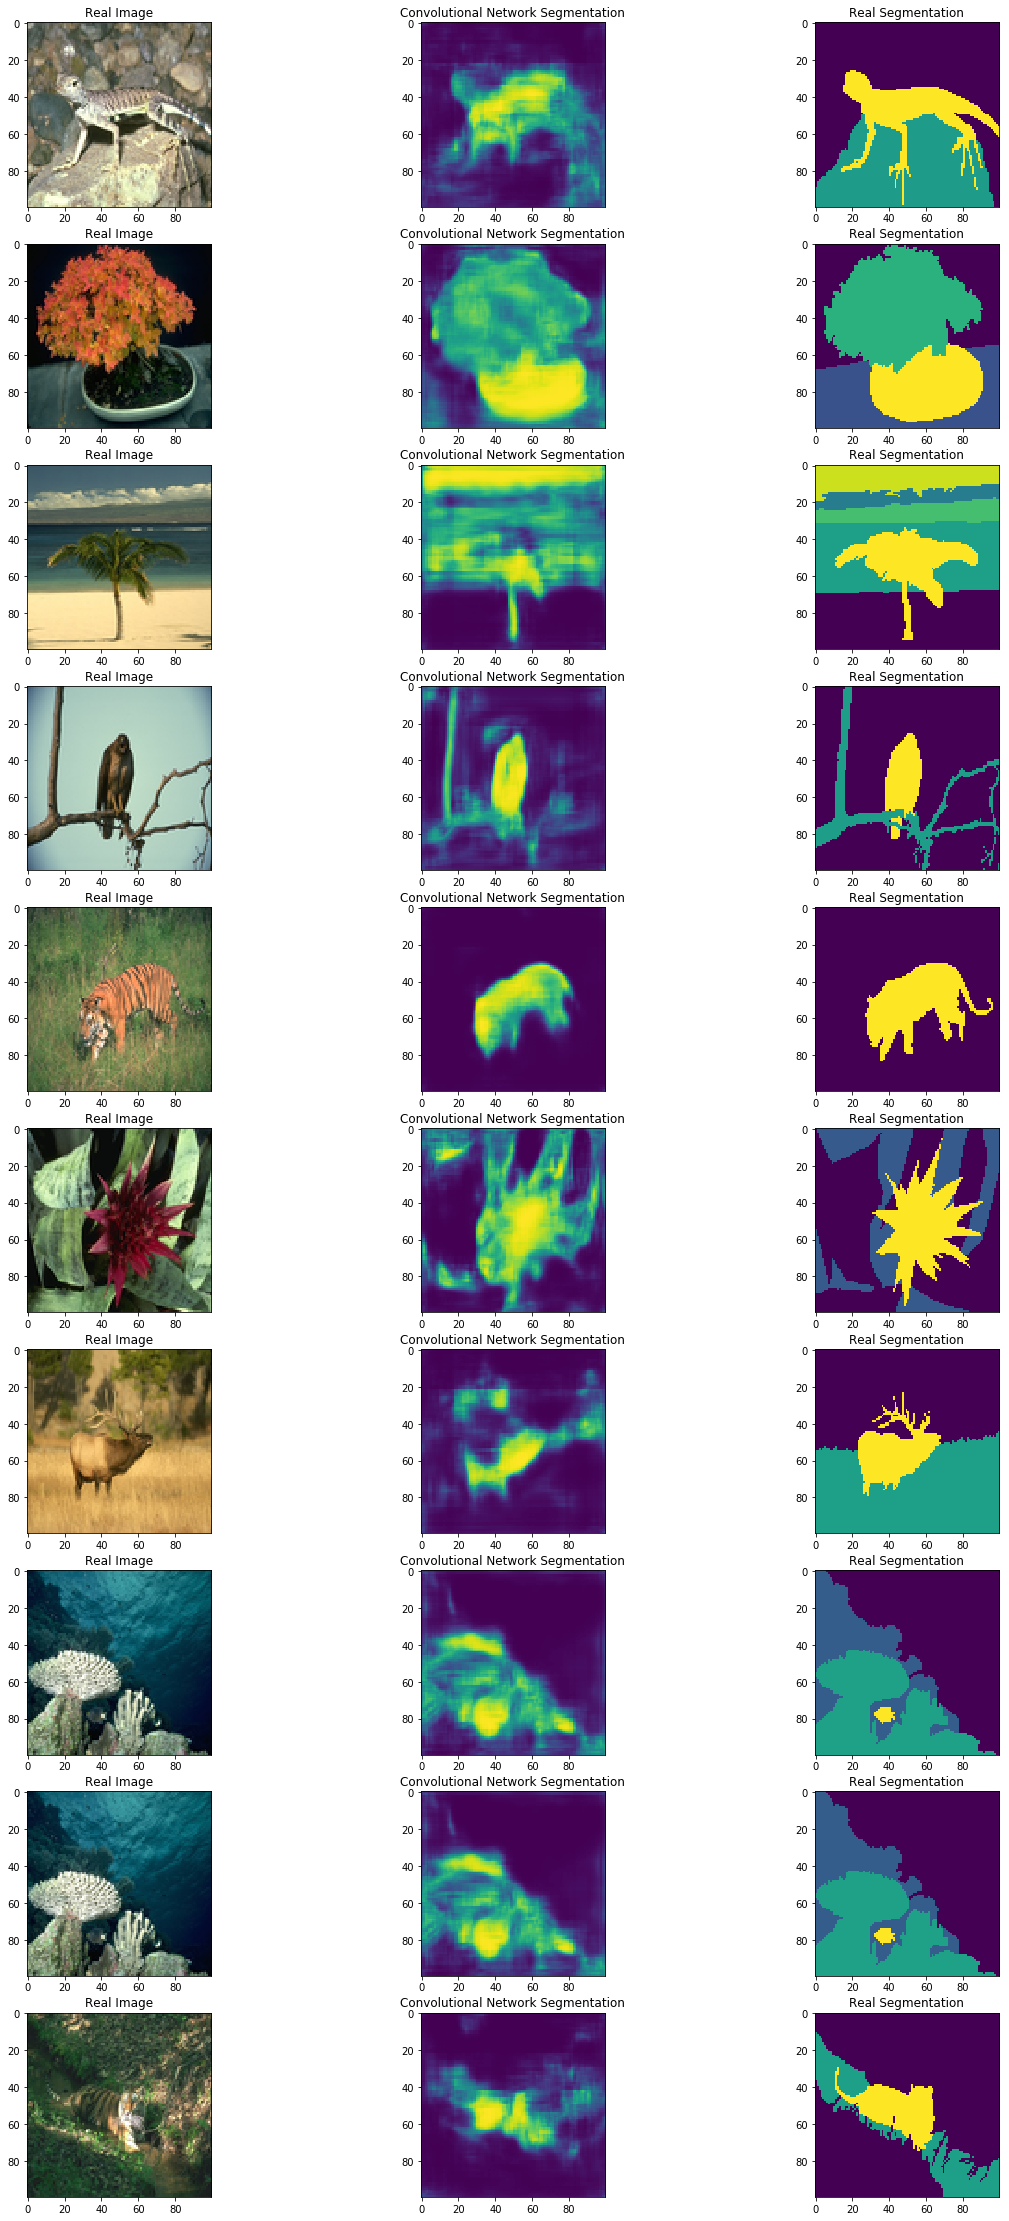

In [72]:
compare_images(conv_propio,dataset='train')

Precision in test dataset: [0.79966157 0.63562753]
Recall in test dataset: [0.86846484 0.5132878 ]


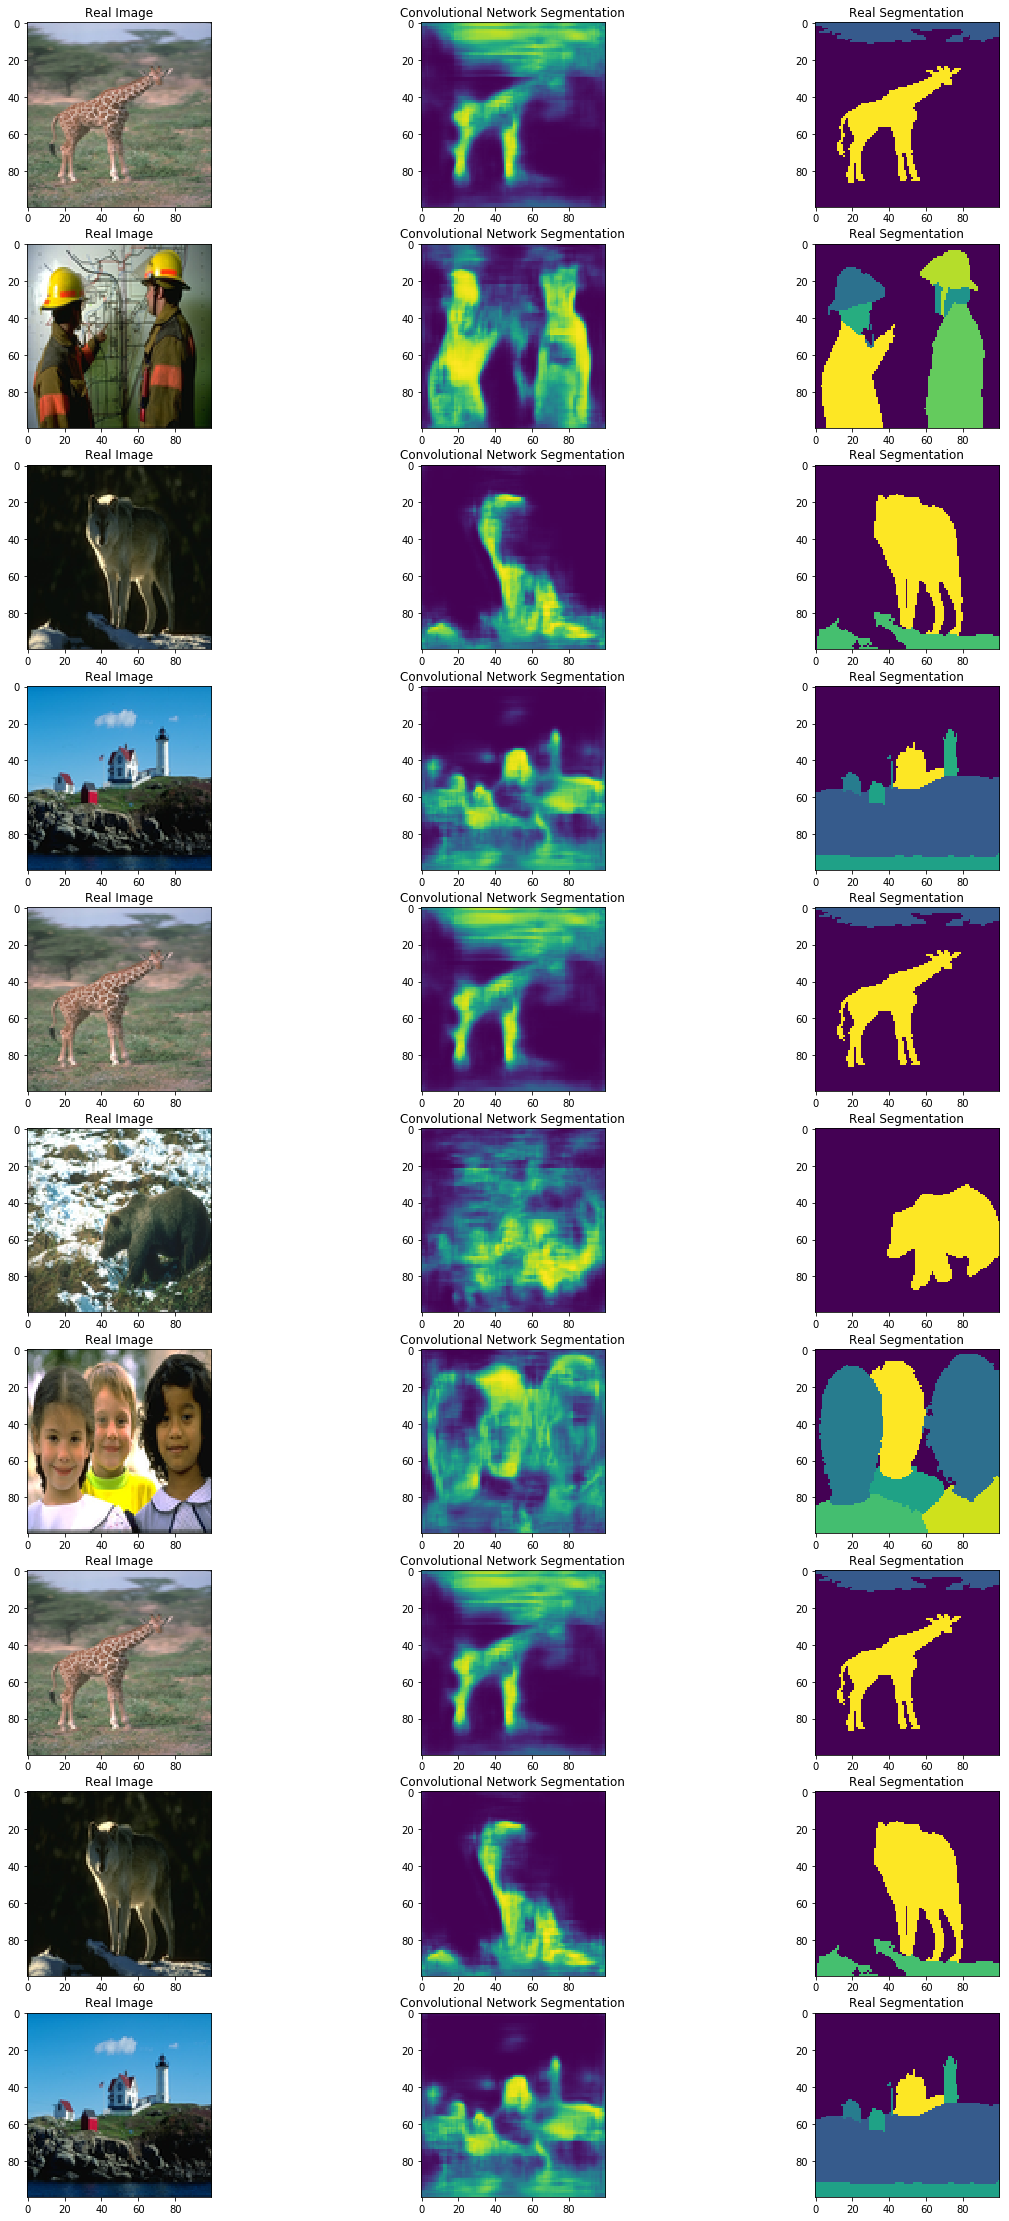

In [73]:
compare_images(conv_propio)